In [1]:

import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data import DataLoader
import random

# Set the seed for reproducibility
SEED = 42
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)  # Apply the seed

In [2]:

BATCH_SIZE = 64
INPUT_SIZE = (256, 256)

def count_files_in_directory(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

main_data_dir = r"C:\Users\Josh\Desktop\CUDA\skindiseases"
train_dir = os.path.join(main_data_dir, "train")
val_dir = os.path.join(main_data_dir, "val")
test_dir = os.path.join(main_data_dir, "test")

train_files = count_files_in_directory(train_dir)
val_files = count_files_in_directory(val_dir)
test_files = count_files_in_directory(test_dir)

print(f"Training Dataset: {train_files}")
print(f"Validation Dataset: {val_files}")
print(f"Test Dataset: {test_files}")

Training Dataset: 2800
Validation Dataset: 800
Test Dataset: 400


In [3]:

# Load the training dataset to calculate mean and std, and get class labels
train_dataset = datasets.ImageFolder(root=train_dir)
class_n = list(train_dataset.class_to_idx.keys())  # Automatically retrieves class names from folders
print("Class to label mapping:", train_dataset.class_to_idx)

Class to label mapping: {'Acne': 0, 'Eczema': 1, 'Normal': 2, 'Perioral Dermatitis': 3, 'Psoriasis': 4, 'Rosacea': 5, 'Seborrheic Dermatitis': 6, 'Tinea Faciei': 7}


In [4]:
import cv2

class KMeansSegmentation:
    def __init__(self, n_clusters=8, overlay_alpha=0.5):
        self.n_clusters = n_clusters
        self.overlay_alpha = overlay_alpha

    def __call__(self, img):
        # Convert PIL image to NumPy array
        img_np = np.array(img)

        # Reshape the image to a 2D array of pixels
        pixel_values = img_np.reshape((-1, 3))
        pixel_values = np.float32(pixel_values)

        # Define criteria and apply K-means
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        _, labels, centers = cv2.kmeans(pixel_values, self.n_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Convert centers back to 8-bit values and reshape labels to the original image shape
        centers = np.uint8(centers)
        segmented_image = centers[labels.flatten()]
        segmented_image = segmented_image.reshape(img_np.shape)

        # Convert segmented image to grayscale to create a mask
        gray_segmented = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)
        _, mask = cv2.threshold(gray_segmented, 1, 255, cv2.THRESH_BINARY)

        # Blend the segmented regions back onto the original image
        img_segmented = cv2.addWeighted(img_np, 1 - self.overlay_alpha, segmented_image, self.overlay_alpha, 0)

        # Convert back to PIL Image
        return Image.fromarray(img_segmented)


In [5]:

class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        # Convert PIL Image to NumPy array
        img_np = np.array(img)
        
        # Apply CLAHE on each channel independently if it's a color image
        if len(img_np.shape) == 3:
            channels = cv2.split(img_np)
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            channels = [clahe.apply(channel) for channel in channels]
            img_np = cv2.merge(channels)
        else:
            # Apply CLAHE on grayscale images
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            img_np = clahe.apply(img_np)

        # Convert back to PIL Image
        img_clahe = Image.fromarray(img_np)
        return img_clahe


In [6]:
import numpy as np
from torchvision import transforms
from PIL import Image

MEAN = (0.6181, 0.4643, 0.4194)
STD = (0.1927, 0.1677, 0.1617)


# Define transformations
transform_train = transforms.Compose([
    # Resize to standardize input dimensions
    transforms.Resize(INPUT_SIZE),
    transforms.CenterCrop((227, 227)), 

    # Apply CLAHE
    transforms.RandomApply([CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8))], p=0.5),

     # Apply KMeans segmentation
    transforms.RandomApply([KMeansSegmentation(n_clusters=3, overlay_alpha=0.5)], p=0.3),

    transforms.RandomApply([transforms.RandomRotation(degrees=(0, 20))], p=0.25),
    transforms.RandomApply([transforms.RandomRotation(degrees=(0, 10))], p=0.25),
    transforms.RandomApply([transforms.RandomRotation(degrees=(-20, 0))], p=0.25),
    transforms.RandomApply([transforms.RandomRotation(degrees=(-10, 0))], p=0.25),

    # Subtle affine transformations and other adjustments
    transforms.RandomApply([transforms.RandomAffine(degrees=5, translate=(0.02, 0.02), shear=2)], p=0.3),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.05, p=0.2)], p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.4),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.7),
    transforms.RandomApply([transforms.RandomGrayscale(p=1.0)], p=0.2),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.5),
    transforms.RandomApply([transforms.RandomAdjustSharpness(sharpness_factor=1.5)], p=0.3),

    # Convert to tensor and normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Validation and test transformations
transform_val_test = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.CenterCrop((227, 227)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Load the datasets with the new transforms
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform_val_test)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_val_test)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [7]:
# Get a batch of images and labels from the DataLoader
images, labels = next(iter(train_loader))
print(images.shape)  

torch.Size([64, 3, 227, 227])


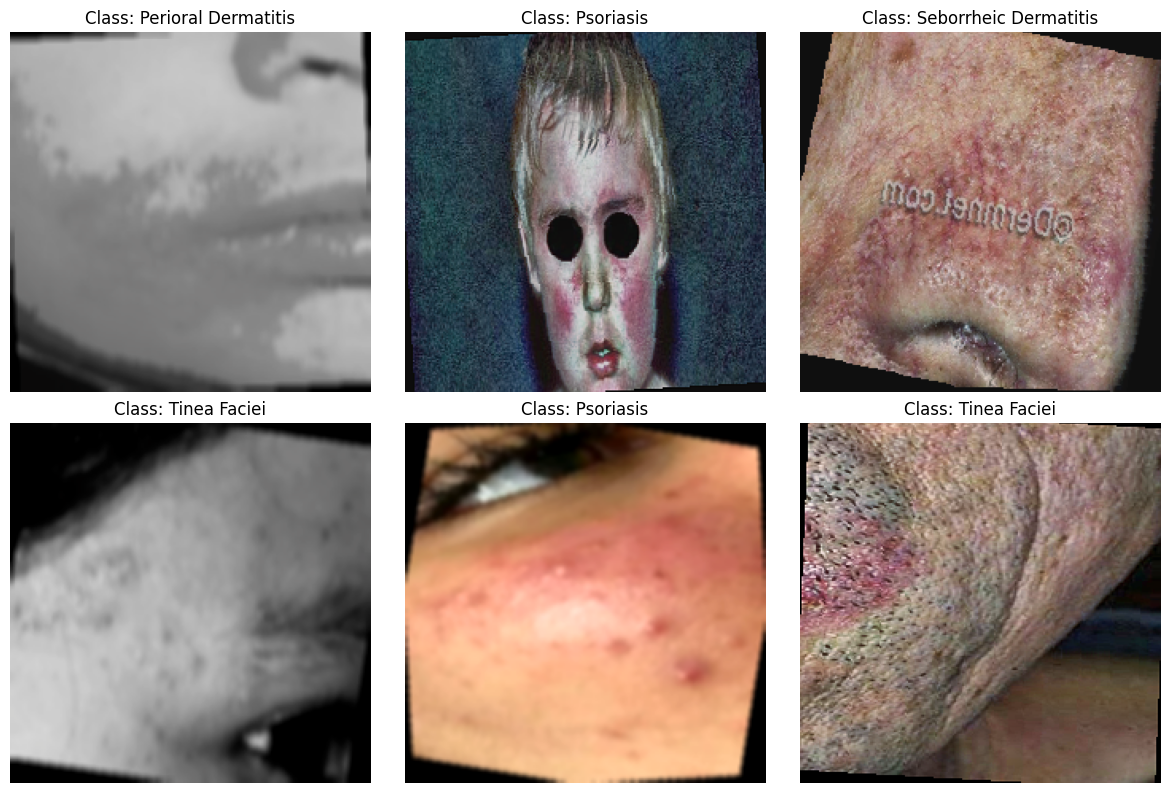

In [8]:

# Function to unnormalize the image for visualization
def unnormalize(image, mean, std):
    # Convert the tensor to a NumPy array and transpose dimensions to (H, W, C)
    image = image.numpy().transpose((1, 2, 0))  
    
    # Unnormalize by reversing the mean and std normalization
    image = (image * std) + mean  
    
    # Clip values to be between 0 and 1 for valid image display
    image = np.clip(image, 0, 1)  
    return image


# Visualize a batch of images from the train_loader
def visualize_loader(loader, mean, std, class_names, num_images=6):
    # Get a batch of images
    data_iter = iter(loader)
    images, labels = next(data_iter)  

    # Plot the images
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(2, 3, i+1)
        image = unnormalize(images[i], mean, std)  
        plt.imshow(image)
        plt.title(f"Class: {class_names[labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use this function to visualize a batch of images
visualize_loader(train_loader, mean=MEAN, std=STD, class_names=class_n)

In [9]:
import torch
import torch.nn as nn
from torchvision import models

# Load the pre-trained AlexNet model
model = models.alexnet(pretrained=False)  # Set pretrained=False to load custom weights
model.classifier = nn.Sequential(*list(model.classifier.children())[:3])  # Modify classifier to stop at fc6

# Load the custom weights with correction for key mismatches
weight_path = r"C:\Users\Josh\Desktop\CUDA\alexnetmodel\45.pth"  # Replace with your actual path
state_dict = torch.load(weight_path, weights_only=True)

# Remove "model." prefix if it exists, and filter out unnecessary keys for fc7 and fc8
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("model.", "") if k.startswith("model.") else k
    # Filter out keys that belong to layers beyond fc6
    if new_key in model.state_dict().keys():
        new_state_dict[new_key] = v
        
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Load the modified state dictionary into the model
model.load_state_dict(new_state_dict, strict=False)  # Allow for missing keys beyond fc6

# Set model to evaluation mode
model.eval()

from torchsummary import summary

# Define input size (e.g., for AlexNet, it’s typically 3x224x224 for RGB images)
input_size = (3, 227, 227)

# Display the model summary
summary(model, input_size=input_size, device=str(device))

c:\Users\Josh\Desktop\CUDA\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Josh\Desktop\CUDA\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          23,296
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [10]:
def extract_features(data_loader):
    features = []
    labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for images, target_labels in data_loader:
            images = images.to(device)
            
            # Extract features using the model up to fc6
            output_features = model(images)
            
            # Append extracted features and labels to the list
            features.append(output_features.cpu().numpy())  # Convert to CPU NumPy array
            labels.append(target_labels.cpu().numpy())
    
    # Concatenate features and labels from all batches
    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels

# Extract features from the datasets
train_features, y_train = extract_features(train_loader)
val_features, y_val = extract_features(val_loader)
test_features, y_test = extract_features(test_loader)

# Save the extracted features and labels
np.save('train_features.npy', train_features)
np.save('y_train.npy', y_train)
np.save('val_features.npy', val_features)
np.save('y_val.npy', y_val)
np.save('test_features.npy', test_features)
np.save('y_test.npy', y_test)

In [ ]:
from xgboost import XGBClassifier, callback
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import json

param_space = {
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'max_depth': Integer(3, 6),
    'min_child_weight': Integer(1, 10),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'gamma': Real(0, 5),
    'n_estimators': Integer(300, 800),
    'reg_alpha': Real(0, 5),
    'reg_lambda': Real(1, 5),
}

# Define early stopping callback
es = callback.EarlyStopping(
    rounds=20,
    min_delta=1e-3,
    save_best=True,
    maximize=False
)

# Initial model with early stopping callback
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_n),
    random_state=SEED,
    eval_metric='mlogloss',
    tree_method='hist',
    device='cuda',
    callbacks=[es]
)

bayes_search = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=param_space,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    n_jobs=3,
    random_state=SEED,
    verbose=3
)


# Perform Bayesian search
bayes_search.fit(
    train_features, y_train,
    eval_set=[(val_features, y_val)],
    verbose=3
)

# Extract the best parameters
best_params = bayes_search.best_params_
print("Best hyperparameters found:", best_params)

# Initialize a new XGBClassifier with best parameters
optimized_xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_n),
    random_state=SEED,
    eval_metric='mlogloss',
    tree_method='hist',
    device='cuda',
    **best_params
)

# Train the optimized model on the full dataset
optimized_xgb_model.fit(train_features, y_train, eval_set=[(val_features, y_val)], verbose=3)

# Save the optimized model and parameters
optimized_xgb_model.save_model('final_xgboost_model.json')
with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_params, f)
print("Model and parameters saved successfully.")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[0]	validation_0-mlogloss:2.03061
[3]	validation_0-mlogloss:1.91981
[6]	validation_0-mlogloss:1.83968
[9]	validation_0-mlogloss:1.78323
[12]	validation_0-mlogloss:1.74200
[15]	validation_0-mlogloss:1.70969
[18]	validation_0-mlogloss:1.68537
[21]	validation_0-mlogloss:1.66629
[24]	validation_0-mlogloss:1.65270
[27]	validation_0-mlogloss:1.64025
[30]	validation_0-mlogloss:1.63246
[33]	validation_0-mlogloss:1.

In [15]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate the optimized model on training, validation, and test sets
train_predictions = optimized_xgb_model.predict(train_features)
train_accuracy = accuracy_score(y_train, train_predictions)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

val_predictions = optimized_xgb_model.predict(val_features)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

test_predictions = optimized_xgb_model.predict(test_features)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Training Accuracy: 82.36%
Validation Accuracy: 42.88%
Test Accuracy: 48.25%


In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score, classification_report

# # Generate and print classification reports for validation and test sets
# val_classification_report = classification_report(y_val, val_predictions, target_names=class_n)
# print("Validation Classification Report:\n", val_classification_report)

# cm = confusion_matrix(y_val, val_predictions)

# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_n, yticklabels=class_n)

# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()


Test Accuracy (Loaded Model): 48.25%
Classification Report:
                        precision    recall  f1-score   support

                 Acne       0.55      0.54      0.55        50
               Eczema       0.38      0.30      0.34        50
               Normal       0.76      0.56      0.64        50
  Perioral Dermatitis       0.49      0.68      0.57        50
            Psoriasis       0.46      0.34      0.39        50
              Rosacea       0.49      0.60      0.54        50
Seborrheic Dermatitis       0.42      0.50      0.45        50
         Tinea Faciei       0.36      0.34      0.35        50

             accuracy                           0.48       400
            macro avg       0.49      0.48      0.48       400
         weighted avg       0.49      0.48      0.48       400



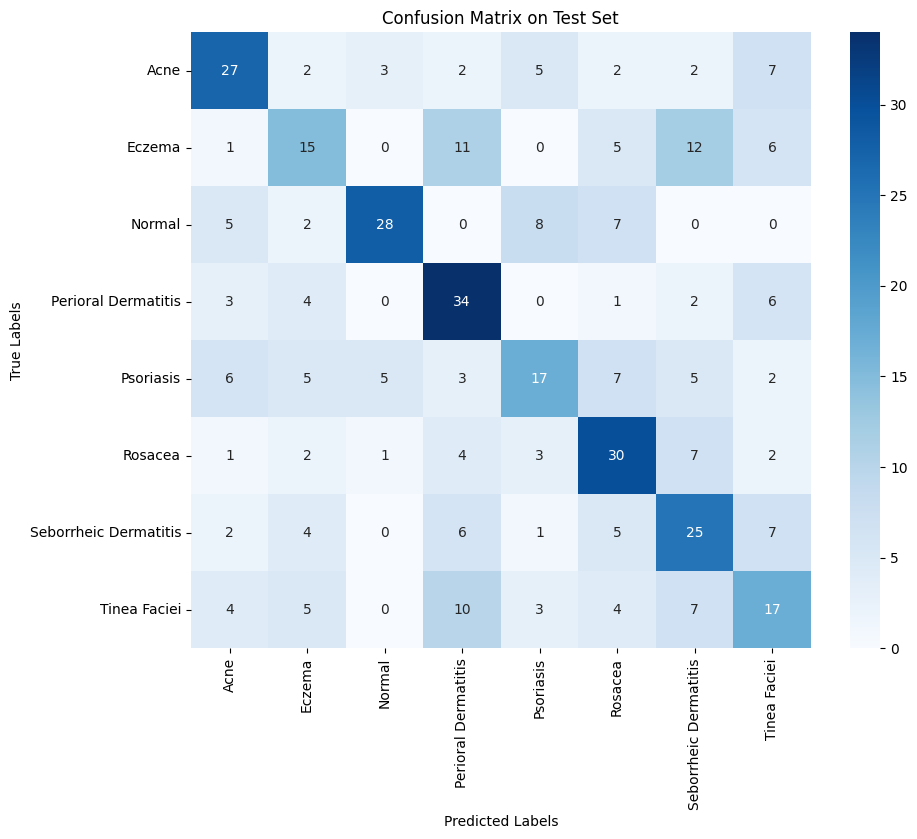

In [ ]:
# Load model from the .model file
loaded_model = XGBClassifier()
loaded_model.load_model(r'C:\Users\Josh\Desktop\CUDA\xgboost\final_xgboost_model.json')  # Ensure path and name are correct

# Confirm evaluation on the test set
test_predictions = loaded_model.predict(test_features)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy (Loaded Model): {test_accuracy * 100:.2f}%')

# Display classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, test_predictions, target_names=class_n))
cm = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_n, yticklabels=class_n)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Set')
plt.show()